<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/13b_CNN_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Verificar si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("GPU no disponible, usando CPU.")

GPU disponible: NVIDIA A100-SXM4-40GB


In [ ]:
device

device(type='cuda')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-05-20 12:12:56--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-05-20 12:12:56--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.05s   

2025-05-20 12:12:56 (14.5 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

In [ ]:
# 2. Definir la arquitectura del modelo con inicialización personalizada
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(7, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    self.fc_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 16 * 16, 128),  # Ajuste de tamaño
      nn.ReLU(),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)
    return x

# 4. Función de entrenamiento
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # mover a GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validación después de cada época
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Guardar las métricas
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

# 5. Función de validación
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # mover a GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    return val_loss, val_acc

# Load Data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5']

In [ ]:
# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_01_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_1 = f['AOI_01_X'][:]
    data_y_1 = f['AOI_01_FC_percentaje'][:]
    print(data_X_1.shape, data_y_1.dtype)

# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_03_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_2 = f['AOI_03_X'][:]
    data_y_2 = f['AOI_03_FC_percentaje'][:]
    print(data_X_2.shape, data_y_2.dtype)

data_X = np.concatenate((data_X_1, data_X_2), axis=0)
data_y = np.concatenate((data_y_1, data_y_2), axis=0)
print(data_X.shape, data_y.shape)

Keys: ['AOI_01_FC_percentaje', 'AOI_01_X', 'AOI_01_y']
(94500, 7, 64, 64) float64
Keys: ['AOI_03_FC_percentaje', 'AOI_03_X', 'AOI_03_y']
(94500, 7, 64, 64) float64
(189000, 7, 64, 64) (189000,)


In [ ]:
data_y.max()

np.float64(98.3642578125)

In [ ]:
filter_y = data_y >= 1 # tomar las que el 1% sea FC
data_y = np.zeros(data_y.shape)
data_y[filter_y] = 1
data_y = data_y.reshape(-1, 1)
data_y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
data_X.shape, data_y.shape

((189000, 7, 64, 64), (189000, 1))

In [ ]:
data_y.sum()

np.float64(82511.0)

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X,
                                                    data_y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()

print(X_train.shape, y_train.shape)

torch.Size([151200, 7, 64, 64]) torch.Size([151200])


In [ ]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long).squeeze()

print(X_test.shape, y_test.shape)

torch.Size([37800, 7, 64, 64]) torch.Size([37800])


In [ ]:
# Agrupar en un dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
# Inicializar el modelo y aplicar la inicialización personalizada
model = CNN().to(device) # mover a GPU

# 3. Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Listas para guardar las métricas
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256,# 32 con CPU GPU 01... 256 con GPU 02
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256,# 32 con CPU GPU 01 ... 256 con GPU 02
                         shuffle=False, num_workers=2)

## Train

In [ ]:
# 6. Entrenar el modelo
train(model, train_loader, test_loader, criterion, optimizer, epochs=100)
# 100 iteraciones eran mucho ... a la proxima solo 50

Epoch 1/100, Train Loss: 0.8302, Train Accuracy: 54.47%, Val Loss: 0.6838, Val Accuracy: 56.33%
Epoch 2/100, Train Loss: 0.6831, Train Accuracy: 56.29%, Val Loss: 0.6764, Val Accuracy: 56.33%
Epoch 3/100, Train Loss: 0.6536, Train Accuracy: 58.19%, Val Loss: 0.6202, Val Accuracy: 63.66%
Epoch 4/100, Train Loss: 0.4938, Train Accuracy: 75.82%, Val Loss: 0.4415, Val Accuracy: 81.15%
Epoch 5/100, Train Loss: 0.3628, Train Accuracy: 84.57%, Val Loss: 0.3656, Val Accuracy: 88.02%
Epoch 6/100, Train Loss: 0.3289, Train Accuracy: 86.37%, Val Loss: 0.2634, Val Accuracy: 90.00%
Epoch 7/100, Train Loss: 0.3502, Train Accuracy: 84.36%, Val Loss: 0.2760, Val Accuracy: 89.52%
Epoch 8/100, Train Loss: 0.5586, Train Accuracy: 67.95%, Val Loss: 0.5779, Val Accuracy: 65.46%
Epoch 9/100, Train Loss: 0.5459, Train Accuracy: 69.09%, Val Loss: 0.5732, Val Accuracy: 65.67%
Epoch 10/100, Train Loss: 0.3717, Train Accuracy: 82.22%, Val Loss: 0.7064, Val Accuracy: 65.57%
Epoch 11/100, Train Loss: 0.4112, Train

In [ ]:
pathSavePlots = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Figures_Models/'

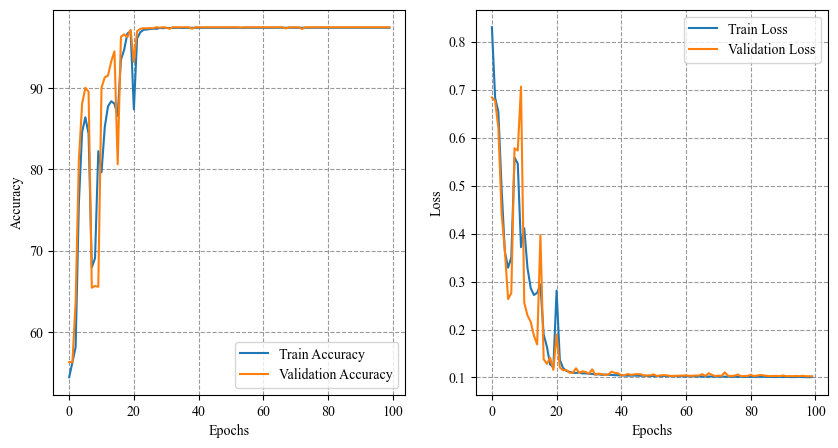

In [ ]:
# 7. Graficar precisión y pérdida
fig = plt.figure(figsize=(10,5))

# Precisión
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_acc_history, label='Train Accuracy')
ax.plot(val_acc_history, label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(color='grey', ls='--', alpha=0.8)

# Pérdida
ax = fig.add_subplot(1, 2, 2)
ax.plot(train_loss_history, label='Train Loss')
ax.plot(val_loss_history, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(color='grey', ls='--', alpha=0.8)

plt.savefig(pathSavePlots + f'Training_CNN_GPU_03.png',
            dpi=500,
            bbox_inches = 'tight',
            pad_inches=0.25)

plt.show()


# Save model

In [ ]:
path_save_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models/'
name_model = 'model_CNN_GPU_03.pth' # 20 epochs
# el modelo 03 toma el AOI 1 y AOI 3 para el entrenamiento

torch.save(model.state_dict(), path_save_models + name_model)

In [ ]:
os.listdir('/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models')

['model_RegLog_002.pkl',
 'model_RegLog_003.pkl',
 'model_RegLog_004.pkl',
 'model_RegLog_005.pkl',
 'model_RegLog_006.pkl',
 'model_RegLog_007.pkl',
 'model_RegLog_008.pkl',
 'model_RegLog_009.pkl',
 'model_RegLog_010.pkl',
 'model_RegLog_001.pkl',
 'model_RegLog_011.pkl',
 'model_RegLog_012.pkl',
 'model_RegLog_013.pkl',
 'model_RegLog_014.pkl',
 'model_RegLog_015.pkl',
 'model_RegLog_016.pkl',
 'model_RegLog_017.pkl',
 'model_RegLog_018.pkl',
 'model_RegLog_019.pkl',
 'model_RegLog_020.pkl',
 'model_RegLog_021.pkl',
 'model_RegLog_022.pkl',
 'model_RegLog_023.pkl',
 'model_RegLog_024.pkl',
 'model_RegLog_025.pkl',
 'model_RegLog_026.pkl',
 'model_RegLog_027.pkl',
 'model_RegLog_028.pkl',
 'model_RegLog_029.pkl',
 'model_RegLog_030.pkl',
 'df_30models_LogReg.csv',
 'model_RandForest_001.pkl',
 'model_RandForest_002.pkl',
 'model_RandForest_003.pkl',
 'model_RandForest_004.pkl',
 'model_RandForest_005.pkl',
 'model_RandForest_006.pkl',
 'model_RandForest_007.pkl',
 'model_RandForest_0

# End